In [1]:
!pip install langgraph langchain_openai langchain_core httpx

DEPRECATION: Loading egg at /Users/kunieda/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tensorboardX-2.6.2.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/kunieda/.pyenv/versions/3.11.9/lib/python3.11/site-packages/six-1.16.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/kunieda/.pyenv/versions/3.11.9/lib/python3.11/site-packages/cycler-0.12.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/kunieda/.pyenv/versions/3

In [2]:
import os
from typing import List
from langgraph.graph import StateGraph
from langchain_openai import AzureChatOpenAI

#from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate


import os

#os.environ["OPENAI_API_VERSION"] = "2024-xx-xx-preview"
#os.environ["AZURE_OPENAI_ENDPOINT"] = "https:/xxxxx.openai.azure.com"
#os.environ["AZURE_OPENAI_API_KEY"] = "xxxxxx"

#上にベタがきしている場合は、下4行はコメントアウトする
from google.colab import userdata
os.environ["OPENAI_API_VERSION"] = userdata.get("OPENAI_API_VERSION")
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get("AZURE_OPENAI_ENDPOINT")
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get("AZURE_OPENAI_API_KEY")


model = AzureChatOpenAI(
    azure_deployment="gpt-4o",  # or your deployment
    temperature=0,
)



ModuleNotFoundError: No module named 'google.colab'

In [3]:
# グラフを流れるStateの方の定義
class State(BaseModel):
    message_type: str = Field(default = "", description="ユーザからの質問の分類結果")
    query: str = Field(default = "", description="これまでのプロンプト内容")
    AI_messages: str = Field(default = "", description="AIからのメッセージ内容")
    bool_time: bool = Field(default = False, description="時刻情報が含まれているかどうかの判定結果")
    advance_messages: str = Field(default = "", description="追加質問のユーザ回答")


# 日付か天気かの質問分類器の出力
class MessageType(BaseModel):
    message_type: str = Field(description="ユーザからの質問の分類結果", example="search")

# 天気の質問において、必要情報がすでに埋まっているかを判定する判定器の出力
class TimeType(BaseModel):
    message_type: bool = Field(description="ユーザ質問に時刻の情報が含めれているかどうかの真偽値(bool)", example=True)

# 今日、明日、明後日のどのワークフローを選択するかの分類器の出力
class ToolType(BaseModel):
    message_type: str = Field(description="どのツールを利用するかの判定結果", example="tool01")

output_parser = StrOutputParser()

In [4]:
from langgraph.errors import NodeInterrupt

def interrupt(State):
    print("--interrupt--")
    if not State.bool_time:
      raise NodeInterrupt("天気を知りたい時間を入力してください")

    return State


def chat_w1(State):
    print("--chat_w1--")
    if State.query:
        sys_prompt = "あなたはユーザからの質問を繰り返してください。その後、質問に回答してください。ただし今日の午前は雨で、午後は雪です"

        prompt = None
        if not State.advance_messages:
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",sys_prompt),
                    ("human", "{user_input}")
                ]
            )
        else:
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",sys_prompt),
                    ("human", "{user_input}"),
                    ("assistant", "天気を知りたい時間を入力してください（例：「午前中」「20時」など）: "),
                    ("human",State.advance_messages)
                ]
            )

        chain = prompt | model | output_parser

        dict = {
                "query":State.query,
                "AI_messages": chain.invoke({"user_input": State.query})
                }

        return dict
    return {
        "AI_messages": "No user input provided"
            }

def chat_d1(State):
    print("--chat_d1--")
    if State.query:
        sys_prompt = "あなたはユーザの質問内容を繰り返し発言した後、それに対して回答してください。ただし今日は10/23です"
        prompt = ChatPromptTemplate.from_messages(
            [
                ("system",sys_prompt),
                ("human", "{user_input}")
            ]
        )

        chain = prompt | model | output_parser

        return {
                "query":State.query,
                "AI_messages": chain.invoke({"user_input": State.query})
                }
    return {
        "AI_messages": "No user input provided"
            }


def chat_w2(State):
    print("--chat_w2--")
    if State.query:
        sys_prompt = "あなたはユーザからの質問を繰り返してください。その後、質問に回答してください。ただし明日の午前は曇りで、午後は霰です"

        prompt = None
        if not State.advance_messages:
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",sys_prompt),
                    ("human", "{user_input}")
                ]
            )
        else:
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",sys_prompt),
                    ("human", "{user_input}"),
                    ("assistant", "天気を知りたい時間を入力してください（例：「午前中」「20時」など）: "),
                    ("human",State.advance_messages)
                ]
            )

        chain = prompt | model | output_parser

        dict = {
                "query":State.query,
                "AI_messages": chain.invoke({"user_input": State.query})
                }

        return dict
    return {
        "AI_messages": "No user input provided"
            }



def chat_d2(State):
    print("--chat_d2--")
    if State.query:
        sys_prompt = "あなたはユーザの質問内容を繰り返し発言した後、それに対して回答してください。ただし明日は10/24です"
        prompt = ChatPromptTemplate.from_messages(
            [
                ("system",sys_prompt),
                ("human", "{user_input}")
            ]
        )

        chain = prompt | model | output_parser

        return {
                "query":State.query,
                "AI_messages": chain.invoke({"user_input": State.query})
                }
    return {
        "AI_messages": "No user input provided"
            }


def chat_w3(State):
    print("--chat_w3--")
    if State.query:
        sys_prompt = "あなたはユーザからの質問を繰り返してください。その後、質問に回答してください。ただし明後日の午前は晴れで、午後は霧です"

        prompt = None
        if not State.advance_messages:
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",sys_prompt),
                    ("human", "{user_input}")
                ]
            )
        else:
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",sys_prompt),
                    ("human", "{user_input}"),
                    ("assistant", "天気を知りたい時間を入力してください（例：「午前中」「20時」など）: "),
                    ("human",State.advance_messages)
                ]
            )

        chain = prompt | model | output_parser

        dict = {
                "query":State.query,
                "AI_messages": chain.invoke({"user_input": State.query})
                }

        return dict
    return {
        "AI_messages": "No user input provided"
            }

def chat_d3(State):
    print("--chat_d3--")
    if State.query:
        sys_prompt = "あなたはユーザの質問内容を繰り返し発言した後、それに対して回答してください。ただし明後日は10/25です"
        prompt = ChatPromptTemplate.from_messages(
            [
                ("system",sys_prompt),
                ("human", "{user_input}")
            ]
        )

        chain = prompt | model | output_parser

        return {
                "query":State.query,
                "AI_messages": chain.invoke({"user_input": State.query})
                }
    return {
        "AI_messages": "No user input provided"
            }


def response(State):
    print("--response--")
    return State

In [5]:

classifier = model.with_structured_output(MessageType)


def classify(State):
    print("--classify--")

    # プロンプトの作成
    classification_prompt = """
    ## You are a message classifier.
    ## ユーザが天気に関しての質問をしていたら"weather"と返答してください。
    ##　それ以外の質問をしていたら、"day"と返答してください。

    """

    if State.query:
        prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",classification_prompt),
                    ("human", "{user_input}")
                ]
            )

        chain = prompt | classifier

        return {
            "message_type": chain.invoke({"user_input": State.query}).message_type,
            "query": State.query
            }
    else:
        return {"AI_messages": "No user input provided"}



classifier_time = model.with_structured_output(TimeType)


def classify_time(State):
    print("--classify_time--")
    # プロンプトの作成
    classification_prompt = """
    ## You are a message classifier.
    ## ユーザが、日付以外の時間を指定して質問している場合（例えば、「午前」「午後」「12時」「5:20」などがある場合）はTrueと返答してください。
    ## そうでない場合はFalseと返答してください。

    TrueかFalse以外では回答しないでください。
    """


    if State.query:
        if State.advance_messages:
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",classification_prompt),
                    ("human", "{user_input}ただし、{advance_messages}")
                ]
            )

        else:
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",classification_prompt),
                    ("human", "{user_input}")
                ]
            )

        chain = prompt | classifier_time

        if State.advance_messages:
            dicts = {
                "bool_time": chain.invoke({"user_input": State.query, "advance_messages": State.advance_messages}).message_type,
                }
            return dicts

        else:
            dicts = {
                "bool_time": chain.invoke({"user_input": State.query}).message_type,
                }
            return dicts
    else:
        return {"AI_messages": "No user input provided"}

In [6]:
#ツールの分類
tools = model.with_structured_output(ToolType)

def select_tool(State):
    print("--select_tool--")
    # プロンプトの作成
    classification_prompt = """
    ## You are a message classifier.
    ## 今日についての質問の場合は"tool01"と返答してください。
    ## 明日についての質問の場合は"tool02"と返答してください。
    ## 明後日についての質問の場合は"tool03"と返答してください。
    """

    user_prompt = """
    # ユーザからの質問内容
    {user_input}
    """

    if State.query:
        prompt = ChatPromptTemplate.from_messages(
                [
                    ("system",classification_prompt),
                    ("human", user_prompt)
                ]
            )

        chain = prompt | tools

        return {
            "message_type": chain.invoke({"user_input": State.query}).message_type,
            }

    else:
        return {"AI_messages": "No user input provided"}


In [7]:
# tool1
#ノードの追加
graph_builder = StateGraph(State)
graph_builder.add_node("select_tool", select_tool)
graph_builder.add_node("classify1", classify)
graph_builder.add_node("classify_time_1", classify_time)
graph_builder.add_node("interrupt_1", interrupt)
graph_builder.add_node("chat_w1", chat_w1)
graph_builder.add_node("chat_d1", chat_d1)
graph_builder.add_node("response1", response)

# エッジの追加
graph_builder.add_edge("classify_time_1", "interrupt_1")
graph_builder.add_edge("chat_d1", "response1")
graph_builder.add_edge("chat_w1", "response1")

# 条件分岐
graph_builder.add_conditional_edges("classify1", lambda state: state.message_type, {"weather": "classify_time_1", "day": "chat_d1"})
graph_builder.add_conditional_edges("interrupt_1", lambda state: state.bool_time, {True: "chat_w1", False: "classify_time_1"})

# tool2
#ノードの追加
graph_builder.add_node("classify2", classify)
graph_builder.add_node("classify_time_2", classify_time)
graph_builder.add_node("interrupt_2", interrupt)
graph_builder.add_node("chat_w2", chat_w2)
graph_builder.add_node("chat_d2", chat_d2)
graph_builder.add_node("response2", response)

# エッジの追加
graph_builder.add_edge("classify_time_2", "interrupt_2")
graph_builder.add_edge("chat_d2", "response2")
graph_builder.add_edge("chat_w2", "response2")
# 条件分岐
graph_builder.add_conditional_edges("classify2", lambda state: state.message_type, {"weather": "classify_time_2", "day": "chat_d2"})
graph_builder.add_conditional_edges("interrupt_2", lambda state: state.bool_time, {True: "chat_w2", False: "classify_time_2"})

# tool3
#ノードの追加
graph_builder.add_node("classify3", classify)
graph_builder.add_node("classify_time_3", classify_time)
graph_builder.add_node("interrupt_3", interrupt)
graph_builder.add_node("chat_w3", chat_w3)
graph_builder.add_node("chat_d3", chat_d3)
graph_builder.add_node("response3", response)

# エッジの追加
graph_builder.add_edge("classify_time_3", "interrupt_3")
graph_builder.add_edge("chat_d3", "response3")
graph_builder.add_edge("chat_w3", "response3")
# 条件分岐
graph_builder.add_conditional_edges("classify3", lambda state: state.message_type, {"weather": "classify_time_3", "day": "chat_d3"})
graph_builder.add_conditional_edges("interrupt_3", lambda state: state.bool_time, {True: "chat_w3", False: "classify_time_3"})

# All
#ノードの追加
graph_builder.add_node("response", response)

# エッジの追加
graph_builder.add_edge("response1", "response")
graph_builder.add_edge("response2", "response")
graph_builder.add_edge("response3", "response")
# 条件分岐
graph_builder.add_conditional_edges("select_tool", lambda state: state.message_type, {"tool01": "classify1", "tool02": "classify2", "tool03": "classify3"})

# 開始位置、終了位置の指定
graph_builder.set_entry_point("select_tool")
graph_builder.set_finish_point("response")

# グラフ構築
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

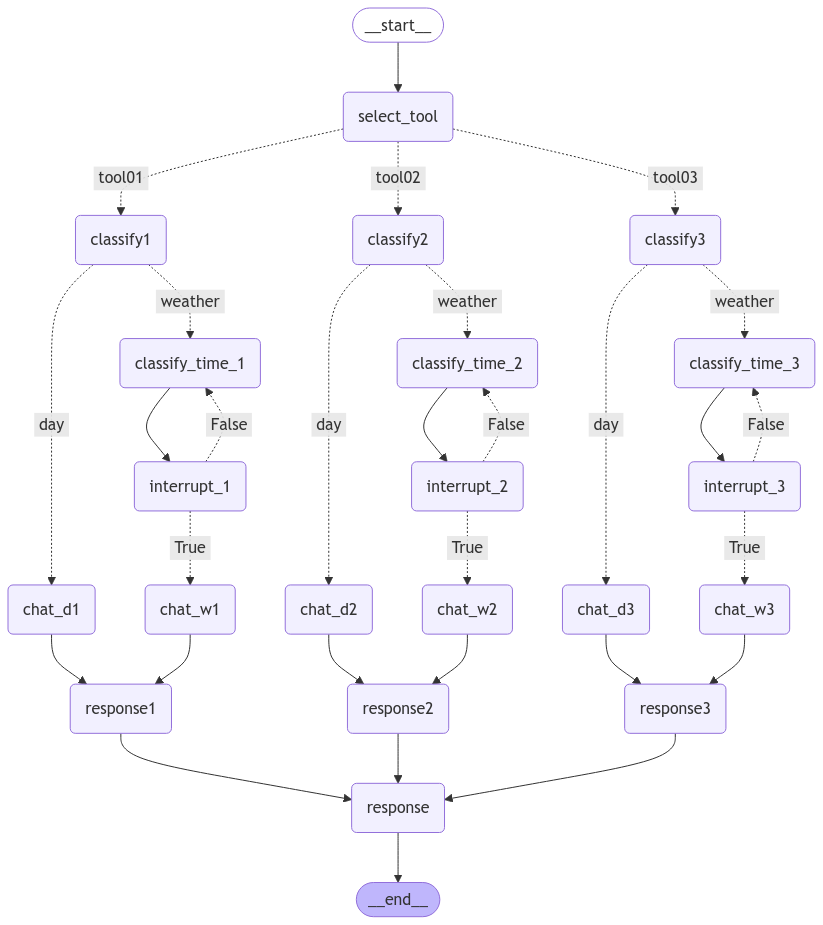

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:

def main():
    interrupt = False
    user_input = input("Your message: ")

    # インタラクションループ
    while user_input.lower() != "exit":
        event_list = []
        # 入力を State 構造に合わせる
        state = {
            "message_type": "",
            "query": user_input,
            "AI_messages": "",
            "bool_time": False,
            "advance_messages": ""
        }

        thread_config = {"configurable": {"thread_id": "1"}}

        # 応答を取得して表示
        last_content = None

        for event in graph.stream(state, thread_config):
            #グラフ途中の中断を検出
            event_list.append(event)
            if "__interrupt__" in event:
                interrupt = True
                break
            # 最後の 'response' から 'messages' の content を取得
            if "response" in event and "AI_messages" in event["response"]:
                last_content = event["response"]["AI_messages"]


        # 最後のメッセージを表示
        if last_content:
            print("Assistant:", last_content)

        #中断した場合の処理を実装
        elif interrupt:
            interrupt = True
            for key in event_list[-2].keys():
                #KEYを取り出す処理。key = next(iter(event_list[-2].keys()))やkey = list(event_list[-2].keys())[0]でも良いし、そちらの方がいいかも
                #中断した処理の直前のノードの名前によって処理を変える。（ただし、今回は一つだけ）
                if "classify_time" in key:
                    while interrupt:
                        #ユーザへの追加のメッセージを依頼する
                        user_input_add_times = input("天気を知りたい時間を入力してください（例：「午前中」「20時」など）: ")

                        #memoryにて履歴が保存されているので、stateを更新する部分だけ用意すれば良い
                        add_state = {
                            "query": user_input,
                            "advance_messages":user_input_add_times,
                        }

                        all_states = []
                        for state in graph.get_state_history(thread_config):
                            all_states.append(state)

                        to_replay = all_states[1]
                        branch_config = graph.update_state(config=to_replay.config, values=add_state)

                        for event in graph.stream(None, branch_config):
                            event_list.append(event)
                            if "__interrupt__" in event:
                                interrupt = True
                                break
                            # 最後の 'response' から 'messages' の content を取得
                            if "response" in event and "AI_messages" in event["response"]:
                                last_content = event["response"]["AI_messages"]


                        # 最後のメッセージを表示
                        if last_content:
                            print("Assistant:", last_content)
                            interrupt = False


        else:
            print("No content found.")

        #次のターンのメッセージ
        user_input = input("Your message: ")
    print("Goodbye!")

In [ ]:
main()